In [1]:
import os
import re
import scipy
import json
import open3d as o3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from pprint import pprint
from plyfile import PlyData, PlyElement
from scipy.spatial import cKDTree
from utils import matplotlib_utils as mpu
from utils.na_bce import NaBCE
from utils.perceptual_model import PerceptualLoss
from utils.log_reg import lr_wrap_regressor, IdentityMethod
from utils.features import compute_features
from utils.octree_coding import partition_octree
from utils.distance_grid import distance_grid_3d, distance_grid_2d
from utils.confidence_intervals import compare_corr_max_conf, corr_ci, rmse_ci, or_ci
from matplotlib import rcParams
from matplotlib import cm

from tqdm.notebook import tqdm, trange
from multiprocessing import Pool
from functools import partial

mpu.default_rc_params(rcParams);
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# import importlib
# import sys
# importlib.reload(sys.modules['utils.distance_grid'])

In [4]:
# Constants and parameters
db_path = '/home/quachmau/datassd/icip2020_perry_quality_repack_bin'
experiment_dir = '/home/quachmau/datassd/experiments/2021_pc_perceptual_loss'
deg_metrics_path = os.path.join('data', 'icip2020_deg_metrics.json')
checkpoint_dir = os.path.join('data', 'model')
checkpoint_dir_tdf = os.path.join('data', 'model_tdf')
degraded_pcs_features_path = os.path.join('data', 'icip2020_degraded_pcs_features.csv')
degraded_pcs_features_preds_path = os.path.join('data', 'icip2020_degraded_pcs_features_preds.csv')
# Block partitioning
block_bits = 6
block_shape = [2**block_bits] * 3
bbox_min = [0,0,0]

In [5]:
os.makedirs('figs', exist_ok=True)

# Load dataset metadata

In [6]:
df = pd.read_csv(os.path.join(db_path, 'dataset.csv'))

In [7]:
pc_names = df['pc_name'].unique()
pc_names

array(['longdress_vox10_1300', 'loot_vox10_1200',
       'redandblack_vox10_1550', 'ricardo10_frame0082',
       'sarah9_frame0023', 'soldier_vox10_0690'], dtype=object)

In [8]:
len(df)

96

In [9]:
df = df.set_index(['pc_name', 'codec_id', 'codec_rate']).sort_index()
df

geometry_bits       mos  \
pc_name                codec_id      codec_rate                            
longdress_vox10_1300   GPCC_OCT_PRED r01                    10  1.197183   
                                     r02                    10  1.464789   
                                     r04                    10  3.436620   
                                     r05                    10  4.000000   
                                     r06                    10  4.295775   
                       GPCC_TRI_PRED r01                    10  1.436620   
                                     r02                    10  2.394366   
                                     r04                    10  3.281690   
                                     r05                    10  3.577465   
                                     r06                    10  4.746479   
                       REF           ref                    10  4.788732   
                       VPCC_AI       r01                    10  2.112676   
                                     r02                    10  2.887324   
                                     r04                    10  3.760563   
                                     r05                    10  4.140845   
                                     rb01                   10  1.647887   
loot_vox10_1200        GPCC_OCT_PRED r01                    10  1.211268   
                                     r02                    10  1.295775   
                                     r04                    10  3.309859   
                                     r05                    10  4.112676   
                                     r06                    10  4.140845   
                       GPCC_TRI_PRED r01                    10  1.464789   
                                     r02                    10  2.112676   
                                     r04                    10  2.887324   
                                     r05                    10  3.352113   
                                     r06                    10  4.464789   
                       REF           ref                    10  4.647887   
                       VPCC_AI       r01                    10  2.154930   
                                     r02                    10  2.830986   
                                     r04                    10  3.704225   
                                     r05                    10  4.000000   
                                     rb01                   10  1.549296   
redandblack_vox10_1550 GPCC_OCT_PRED r01                    10  1.169014   
                                     r02                    10  1.492958   
                                     r04                    10  3.309859   
                                     r05                    10  4.154930   
                                     r06                    10  4.535211   
                       GPCC_TRI_PRED r01                    10  1.732394   
                                     r02                    10  2.338028   
                                     r04                    10  3.239437   
                                     r05                    10  3.281690   
                                     r06                    10  4.788732   
                       REF           ref                    10  4.774648   
                       VPCC_AI       r01                    10  2.323944   
                                     r02                    10  3.056338   
                                     r04                    10  3.915493   
                                     r05                    10  4.253521   
                                     rb01                   10  1.873239   
ricardo10_frame0082    GPCC_OCT_PRED r01                    10  1.211268   
                                     r02                    10  1.619718   
                                     r04                    10  4.267606   
                     

# Loading and preprocessing data

In [10]:
# Separate reference and degraded PCs
refs_data = {}
degs_data = {}
for pc_name in pc_names:
    pc_ref = dict(df.loc[pc_name, 'REF', 'ref'])
    refs_data[pc_name] = pc_ref
    
    pc_degs = df.loc[pc_name]
    for idx, pc_deg in pc_degs.iterrows():
        degs_data[(pc_name, idx[0], idx[1])] = dict(pc_deg)
    
# pprint(refs_data)
# pprint(degs_data)

In [11]:
def load_pc(path):
    plydata = PlyData.read(os.path.join(db_path, path))
    pc_df = pd.DataFrame(plydata['vertex'].data).astype(np.float32)
    new_cols = {x: re.sub('scalar_', '', re.sub(r'_\(\d+\)', '', x)).lower() for x in list(pc_df)}
    pc_df = pc_df.rename(columns=new_cols)
    return pc_df

for pc_name in tqdm(refs_data, desc='Loading reference point clouds'):
    ref_data = refs_data[pc_name]
    ref_data['pc'] = load_pc(os.path.join(db_path, ref_data['relative_path']))
    ref_data['tree'] = cKDTree(ref_data['pc'][['x','y','z']])
    
for (pc_name, codec_id, codec_rate), deg_data in tqdm(degs_data.items(), desc='Loading degraded point clouds'):
    ref_data = refs_data[pc_name]
    
    deg_data['pc'] = load_pc(os.path.join(db_path, deg_data['relative_path']))
    deg_data['tree'] = cKDTree(deg_data['pc'][['x','y','z']], balanced_tree=False)
    deg_data['dists_AB'], deg_data['ngb_AB'] = deg_data['tree'].query(ref_data['pc'][['x','y','z']], n_jobs=-1)
    deg_data['dists_BA'], deg_data['ngb_BA'] = ref_data['tree'].query(deg_data['pc'][['x','y','z']], n_jobs=-1)

# Compute features

In [12]:
for (pc_name, codec_id, codec_rate), deg_data in tqdm(degs_data.items(), desc='Computing features'):
    ref_data = refs_data[pc_name]
    deg_data['features'] = compute_features(ref_data, deg_data)

# pprint({key: x['features'] for key, x in degs_data.items()})

/home/quachmau/code/2021_pc_perceptual_loss/src/utils/features.py:89: RuntimeWarning: divide by zero encountered in true_divide
  psnr_color_AB = 10 * np.log10(1 / mse_color_AB)
/home/quachmau/code/2021_pc_perceptual_loss/src/utils/features.py:90: RuntimeWarning: divide by zero encountered in true_divide
  psnr_color_BA = 10 * np.log10(1 / mse_color_BA)


In [13]:
def esc_latex(s):
    return re.sub('_', '\\_', s)

In [14]:
def pts_to_vx(pts, block_shape, block):
    block.fill(0)
    if pts is None or len(pts) == 0:
        return block
    pts = pts.astype(np.uint32)
    block[pts[:, 0], pts[:, 1], pts[:, 2]] = 1
    return block

def wbce(y_true, y_pred, eps=1e-16, w=0.5):
    assert 0 <= w <= 1
    return np.mean(w * -y_true * np.log(y_pred + eps) - (1 - w) * (1 - y_true) * np.log(1 - y_pred + eps))

def awbce(y_true, y_pred):
    w = np.sum(1 - y_true) / np.prod(y_true.shape)
#     w = (w + 0.5) / 2
    return wbce(y_true, y_pred, w=w)

def focal_loss(y_true, y_pred, alpha=0.75, gamma=2.0):
    pt_1 = np.where(y_true == 1, y_pred, np.ones_like(y_pred))
    pt_0 = np.where(y_true == 0, y_pred, np.zeros_like(y_pred))

    pt_1 = np.clip(pt_1, 1e-3, .999)
    pt_0 = np.clip(pt_0, 1e-3, .999)

    return -np.sum(alpha * np.power(1. - pt_1, gamma) * np.log(pt_1)) - np.sum((1-alpha) * np.power(pt_0, gamma) * np.log(1. - pt_0))


In [15]:
tf.reset_default_graph()
perceptual_loss = PerceptualLoss(checkpoint_dir, block_shape)
perceptual_loss_tdf = PerceptualLoss(checkpoint_dir_tdf, block_shape)
na_bce = NaBCE(block_shape)




Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Restoring checkpoint data/model/model.ckpt-9500
INFO:tensorflow:Restoring parameters from data/model/model.ckpt-9500
Restoring checkpoint data/model_tdf/model.ckpt-9000
INFO:tensorflow:Restoring parameters from data/model_tdf/model.ckpt-9000
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/home/quachmau/code/2021_pc_perceptual_loss/src/utils/na_bce.py:55: RuntimeWarning: divide by zero encountered in true_divide
  dist_mat = np.reshape(np.divide(1, dist_list), [m, m, m])


In [16]:
# Compute block partitioning for reference and degraded point clouds
for pc_name in tqdm(refs_data, desc='Block Partitioning on reference PCs'):
    ref_data = refs_data[pc_name]
    geo_bits = ref_data['geometry_bits']
    octree_bits = geo_bits - block_bits
    ref_pc_xyz = ref_data['pc'][['x','y','z']]
    bbox_max = np.asarray([2**geo_bits] * 3)
    blocks_meta = partition_octree(ref_pc_xyz, bbox_min, bbox_max, octree_bits)['blocks_meta']
    ref_data['bbox_max'] = bbox_max
    ref_data['octree_bits'] = octree_bits
    ref_data['block_bits'] = block_bits
    ref_data['blocks_meta'] = blocks_meta
    
    ref_result = ref_data['blocks_meta']
    block_ids = ref_result.keys()
    for j, block_id in enumerate(block_ids):
        ref_vx = np.zeros(block_shape, dtype=np.float32)
        deg_vx = np.zeros(block_shape, dtype=np.float32)
        ref_block = ref_result[block_id]['block']
        ref_vx = pts_to_vx(ref_block, block_shape, ref_vx)
        # The TDF is precomputed and kept in memory only for reference point clouds
        ref_tdf = distance_grid_3d(ref_block, block_shape, ub=5).astype(np.float32)
        
        ref_result[block_id]['ref_vx'] = ref_vx
        ref_result[block_id]['ref_tdf'] = ref_tdf
    
for (pc_name, codec_id, codec_rate), deg_data in tqdm(degs_data.items(), desc='Block Partitioning on degraded PCs'):
    geo_bits = ref_data['geometry_bits']
    octree_bits = geo_bits - block_bits
    deg_pc_xyz = deg_data['pc'][['x','y','z']]
    bbox_max = np.asarray([2**geo_bits] * 3)
    # ricardo GPCC OCT PRED r02 breaks the 10bits geometry assumption
    # filter out points outside bounds
    deg_pc_xyz = deg_pc_xyz[np.all(deg_pc_xyz.values < bbox_max, axis=1)]
    blocks_meta = partition_octree(deg_pc_xyz, bbox_min, bbox_max, octree_bits)['blocks_meta']
    ref_data['bbox_max'] = bbox_max
    ref_data['octree_bits'] = octree_bits
    ref_data['block_bits'] = block_bits
    deg_data['blocks_meta'] = blocks_meta

In [17]:
# Load deg metrics that were already computed
recompute_deg_metrics = False
if not recompute_deg_metrics and os.path.exists(deg_metrics_path):
    with open(deg_metrics_path, 'r') as f:
        deg_metrics = json.load(f)
else:
    # Initialize data structure for deg_metrics
    deg_metrics = []
    for (pc_name, codec_id, codec_rate), deg_data in tqdm(degs_data.items()):
        # Load data
        ref_data = refs_data[pc_name]
        geo_bits = ref_data['geometry_bits']

        # Compute octree partitioning
        ref_result = refs_data[pc_name]['blocks_meta']
        deg_result = degs_data[(pc_name, codec_id, codec_rate)]['blocks_meta']

        # Identify space occupied by either ref or deg with set of block ids
        block_ids = list(set(ref_result.keys()).union(set(deg_result.keys())))

        deg_metrics.append([{} for i in range(len(block_ids))])

In [18]:
# If changes were made to metrics, invalidating the cache may be needed
# for blocks in deg_metrics:
#     for block in blocks:
#         block.pop('bin_bce', None)
#         block.pop('bin_awbce', None)

In [19]:
# Compute the metrics for each block of each point cloud
for i, ((pc_name, codec_id, codec_rate), deg_data) in enumerate(tqdm(degs_data.items())):
    # Load data
    ref_data = refs_data[pc_name]
    geo_bits = ref_data['geometry_bits']

    # Compute octree partitioning
    ref_result = refs_data[pc_name]['blocks_meta']
    deg_result = degs_data[(pc_name, codec_id, codec_rate)]['blocks_meta']

    # Identify space occupied by either ref or deg with set of block ids
    block_ids = list(set(ref_result.keys()).union(set(deg_result.keys())))
    block_shape = [2**block_bits] * 3
    
    # Preallocate and reuse memory
    ref_vx = np.zeros(block_shape, dtype=np.float32)
    deg_vx = np.zeros(block_shape, dtype=np.float32)
    for j, block_id in enumerate(block_ids):
        ref_block = ref_result[block_id]['block'] if block_id in ref_result else None
        deg_block = deg_result[block_id]['block'] if block_id in deg_result else None
        ref_vx = ref_result[block_id]['ref_vx'] if block_id in ref_result else pts_to_vx(ref_block, block_shape, ref_vx)
        deg_vx = pts_to_vx(deg_block, block_shape, deg_vx)
        
        cur_metrics = deg_metrics[i][j]

        if 'bin_mse' not in cur_metrics:
            mse = np.mean(np.square(ref_vx - deg_vx))
            cur_metrics['bin_mse'] = mse
        
        if 'bin_floss' not in cur_metrics:
            floss = focal_loss(ref_vx, deg_vx)
            cur_metrics['bin_floss'] = floss
            
        if 'bin_bce' not in cur_metrics:
            bce = wbce(ref_vx, deg_vx, w=0.5)
            cur_metrics['bin_bce'] = bce
        
        if 'bin_bce_0.75' not in cur_metrics:
            bce = wbce(ref_vx, deg_vx, w=0.75)
            cur_metrics['bin_bce_0.75'] = bce
            
        if 'bin_na_bce_5' not in cur_metrics:
            bce = na_bce(ref_vx, deg_vx)
            cur_metrics['bin_na_bce_5'] = bce
        
        if 'bin_awbce' not in cur_metrics:
            bce = awbce(ref_vx, deg_vx)
            cur_metrics['bin_awbce'] = bce

        if 'bin_ploss_mean' not in cur_metrics or any(f'bin_ploss_{i:02d}' not in cur_metrics for i in range(perceptual_loss.filters)):
            ploss = perceptual_loss(ref_vx, deg_vx, features=True)
            cur_metrics['bin_ploss_mean'] = np.mean(ploss)
            for k in range(perceptual_loss.filters):
                cur_metrics[f'bin_ploss_{k:02d}'] = ploss[k]
            
        
        if any(metric not in cur_metrics for metric in ['tdf_5_mse', 'tdf_5_ploss_mean']) or any(f'tdf_5_ploss_{i:02d}' not in cur_metrics for i in range(perceptual_loss_tdf.filters)):
            ref_tdf = ref_result[block_id]['ref_tdf'] if block_id in ref_result else distance_grid_3d(ref_block, block_shape, ub=5).astype(np.float32)
            deg_tdf = distance_grid_3d(deg_block, block_shape, ub=5).astype(np.float32)
            
            if 'tdf_5_mse' not in cur_metrics:
                tdf_5_mse = np.mean(np.square(ref_tdf - deg_tdf))
                cur_metrics['tdf_5_mse'] = tdf_5_mse
            
            if 'tdf_5_ploss_mean' not in cur_metrics or any(f'tdf_5_ploss_{i:02d}' not in cur_metrics for i in range(perceptual_loss_tdf.filters)):
                tdf_5_ploss = perceptual_loss_tdf(ref_tdf, deg_tdf, features=True)
                cur_metrics['tdf_5_ploss_mean'] = np.mean(tdf_5_ploss)
                for k in range(perceptual_loss_tdf.filters):
                    cur_metrics[f'tdf_5_ploss_{k:02d}'] = tdf_5_ploss[k]

In [20]:
print('Point cloud', deg_block)
print('Shape', block_shape)
dg = distance_grid_3d(deg_block, block_shape, ub=1) # ub: Upper bound value
print('Distance grid (part)', dg[0, -3:, :4]) # Just print a slice
print('Unique distance grid values', np.unique(dg))

Point cloud [[36. 63. 17.]
 [36. 63. 18.]
 [35. 62. 19.]
 ...
 [35. 63. 21.]
 [36. 63. 19.]
 [36. 63. 20.]]
Shape [64, 64, 64]
Distance grid (part) [[0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Unique distance grid values [0. 1.]


In [21]:
# Save the metrics to the disk
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

with open(deg_metrics_path, 'w') as f:
    json.dump(deg_metrics, f, cls=NumpyEncoder)

In [22]:
deg_metrics_df = [pd.DataFrame(x) for x in deg_metrics]

In [23]:
# For each previously computed metric, compute L2 and L1 aggregation
# Mean is the same as L1 as the computed metrics are always >= 0
metrics = list(deg_metrics_df[0].columns)
for i, deg_data in enumerate(degs_data.values()):
    mean_metrics = dict(deg_metrics_df[i].mean())
    l2_metrics = np.sqrt(np.square(deg_metrics_df[i]).mean())

    for metric in metrics:
        deg_data['features'][metric + '_mean'] = mean_metrics[metric]
        deg_data['features'][metric + '_l2'] = l2_metrics[metric]

In [24]:
# Build a dataframe with degraded PC info and features
degs_df = [{'pc_name': k[0], 'codec_id': k[1], 'codec_rate': k[2],
            'geometry_bits': v['geometry_bits'], 'mos': v['mos'], 'mos_ci': v['mos_ci'],
            'relative_path': v['relative_path'], 'radius': v['radius'],
            **v['features']} for k, v in degs_data.items()]
degs_df = pd.DataFrame(degs_df)
os.makedirs('data', exist_ok=True)
degs_df.to_csv(degraded_pcs_features_path, index=False)
degs_df

,pc_name,codec_id,codec_rate,geometry_bits,mos,mos_ci,relative_path,radius,input_points,output_points,out_in_points_ratio,d1_mse_AB,d1_mse_BA,max_d1_mse,d1_psnr_AB,d1_psnr_BA,min_d1_psnr,max_energy,d2_mse_AB,d2_mse_BA,max_d2_mse,d2_psnr_AB,d2_psnr_BA,min_d2_psnr,y_mse_color_AB,y_mse_color_BA,max_y_mse_color,y_psnr_color_AB,y_psnr_color_BA,min_y_psnr_color,u_mse_color_AB,u_mse_color_BA,max_u_mse_color,u_psnr_color_AB,u_psnr_color_BA,min_u_psnr_color,v_mse_color_AB,v_mse_color_BA,max_v_mse_color,v_psnr_color_AB,v_psnr_color_BA,min_v_psnr_color,bin_mse_mean,bin_mse_l2,bin_floss_mean,bin_floss_l2,bin_bce_mean,bin_bce_l2,bin_ploss_mean_mean,bin_ploss_mean_l2,bin_ploss_00_mean,bin_ploss_00_l2,bin_ploss_01_mean,bin_ploss_01_l2,bin_ploss_02_mean,bin_ploss_02_l2,bin_ploss_03_mean,bin_ploss_03_l2,bin_ploss_04_mean,bin_ploss_04_l2,bin_ploss_05_mean,bin_ploss_05_l2,bin_ploss_06_mean,bin_ploss_06_l2,bin_ploss_07_mean,bin_ploss_07_l2,bin_ploss_08_mean,bin_ploss_08_l2,bin_ploss_09_mean,bin_ploss_09_l2,bin_ploss_10_mean,bin_ploss_10_l2,bin_ploss_11_mean,bin_ploss_11_l2,bin_ploss_12_mean,bin_ploss_12_l2,bin_ploss_13_mean,bin_ploss_13_l2,bin_ploss_14_mean,bin_ploss_14_l2,bin_ploss_15_mean,bin_ploss_15_l2,bin_ploss_16_mean,bin_ploss_16_l2,bin_ploss_17_mean,bin_ploss_17_l2,bin_ploss_18_mean,bin_ploss_18_l2,bin_ploss_19_mean,bin_ploss_19_l2,bin_ploss_20_mean,bin_ploss_20_l2,bin_ploss_21_mean,bin_ploss_21_l2,bin_ploss_22_mean,bin_ploss_22_l2,bin_ploss_23_mean,bin_ploss_23_l2,bin_ploss_24_mean,bin_ploss_24_l2,bin_ploss_25_mean,bin_ploss_25_l2,bin_ploss_26_mean,bin_ploss_26_l2,bin_ploss_27_mean,bin_ploss_27_l2,bin_ploss_28_mean,bin_ploss_28_l2,bin_ploss_29_mean,bin_ploss_29_l2,bin_ploss_30_mean,bin_ploss_30_l2,bin_ploss_31_mean,bin_ploss_31_l2,tdf_5_mse_mean,tdf_5_mse_l2,tdf_5_ploss_mean_mean,tdf_5_ploss_mean_l2,tdf_5_ploss_00_mean,tdf_5_ploss_00_l2,tdf_5_ploss_01_mean,tdf_5_ploss_01_l2,tdf_5_ploss_02_mean,tdf_5_ploss_02_l2,tdf_5_ploss_03_mean,tdf_5_ploss_03_l2,tdf_5_ploss_04_mean,tdf_5_ploss_04_l2,tdf_5_ploss_05_mean,tdf_5_ploss_05_l2,tdf_5_ploss_06_mean,tdf_5_ploss_06_l2,tdf_5_ploss_07_mean,tdf_5_ploss_07_l2,tdf_5_ploss_08_mean,tdf_5_ploss_08_l2,tdf_5_ploss_09_mean,tdf_5_ploss_09_l2,tdf_5_ploss_10_mean,tdf_5_ploss_10_l2,tdf_5_ploss_11_mean,tdf_5_ploss_11_l2,tdf_5_ploss_12_mean,tdf_5_ploss_12_l2,tdf_5_ploss_13_mean,tdf_5_ploss_13_l2,tdf_5_ploss_14_mean,tdf_5_ploss_14_l2,tdf_5_ploss_15_mean,tdf_5_ploss_15_l2,tdf_5_ploss_16_mean,tdf_5_ploss_16_l2,tdf_5_ploss_17_mean,tdf_5_ploss_17_l2,tdf_5_ploss_18_mean,tdf_5_ploss_18_l2,tdf_5_ploss_19_mean,tdf_5_ploss_19_l2,tdf_5_ploss_20_mean,tdf_5_ploss_20_l2,tdf_5_ploss_21_mean,tdf_5_ploss_21_l2,tdf_5_ploss_22_mean,tdf_5_ploss_22_l2,tdf_5_ploss_23_mean,tdf_5_ploss_23_l2,tdf_5_ploss_24_mean,tdf_5_ploss_24_l2,tdf_5_ploss_25_mean,tdf_5_ploss_25_l2,tdf_5_ploss_26_mean,tdf_5_ploss_26_l2,tdf_5_ploss_27_mean,tdf_5_ploss_27_l2,tdf_5_ploss_28_mean,tdf_5_ploss_28_l2,tdf_5_ploss_29_mean,tdf_5_ploss_29_l2,tdf_5_ploss_30_mean,tdf_5_ploss_30_l2,tdf_5_ploss_31_mean,tdf_5_ploss_31_l2,bin_awbce_mean,bin_awbce_l2,bin_bce_0.75_mean,bin_bce_0.75_l2,bin_na_bce_5_mean,bin_na_bce_5_l2
0,longdress_vox10_1300,GPCC_OCT_PRED,r01,10,1.197183,0.172641,longdress_vox10_1300_GPCC_OCT_PRED_r01.ply,17,857966,15685,54.699777,16.532005,9.293784,16.532005,52.793956,55.295286,52.793956,3145728,5.406191,7.989084,7.989084,57.648298,55.952242,55.952242,0.009323,0.009348,0.009348,20.304297,20.292951,20.292951,0.002021,0.002016,0.002021,26.943584,26.954745,26.943584,0.003141,0.003056,0.003141,25.028735,25.148379,25.028735,0.014845,0.018662,19898.012682,25023.893650,0.264349,0.332732,0.497232,0.630740,0.279501,0.368985,0.191247,0.245693,0.354102,0.454386,0.168613,0.216453,2.412113,3.097343,0.395961,0.517016,0.611808,0.785962,0.421360,0.540785,0.524551,0.679712,0.388392,0.502072,0.522672,0.686705,0.342130,0.433292,1.899015,2.429097,0.469605,0.604735,0.653345,0.852788,0.412434,0.529518,0.268262,0.351912,0.0,0.0,0.482713,0.609510,0.269545,0.343542,0.479212,0.6

In [25]:
# Restore saved data
# degs_df = pd.read_csv('data/icip2020_degraded_pcs_features.csv')
# degs_df

In [26]:
degs_df[[x for x in degs_df.columns if 'ploss' in x]].describe()

,bin_ploss_mean_mean,bin_ploss_mean_l2,bin_ploss_00_mean,bin_ploss_00_l2,bin_ploss_01_mean,bin_ploss_01_l2,bin_ploss_02_mean,bin_ploss_02_l2,bin_ploss_03_mean,bin_ploss_03_l2,bin_ploss_04_mean,bin_ploss_04_l2,bin_ploss_05_mean,bin_ploss_05_l2,bin_ploss_06_mean,bin_ploss_06_l2,bin_ploss_07_mean,bin_ploss_07_l2,bin_ploss_08_mean,bin_ploss_08_l2,bin_ploss_09_mean,bin_ploss_09_l2,bin_ploss_10_mean,bin_ploss_10_l2,bin_ploss_11_mean,bin_ploss_11_l2,bin_ploss_12_mean,bin_ploss_12_l2,bin_ploss_13_mean,bin_ploss_13_l2,bin_ploss_14_mean,bin_ploss_14_l2,bin_ploss_15_mean,bin_ploss_15_l2,bin_ploss_16_mean,bin_ploss_16_l2,bin_ploss_17_mean,bin_ploss_17_l2,bin_ploss_18_mean,bin_ploss_18_l2,bin_ploss_19_mean,bin_ploss_19_l2,bin_ploss_20_mean,bin_ploss_20_l2,bin_ploss_21_mean,bin_ploss_21_l2,bin_ploss_22_mean,bin_ploss_22_l2,bin_ploss_23_mean,bin_ploss_23_l2,bin_ploss_24_mean,bin_ploss_24_l2,bin_ploss_25_mean,bin_ploss_25_l2,bin_ploss_26_mean,bin_ploss_26_l2,bin_ploss_27_mean,bin_ploss_27_l2,bin_ploss_28_mean,bin_ploss_28_l2,bin_ploss_29_mean,bin_ploss_29_l2,bin_ploss_30_mean,bin_ploss_30_l2,bin_ploss_31_mean,bin_ploss_31_l2,tdf_5_ploss_mean_mean,tdf_5_ploss_mean_l2,tdf_5_ploss_00_mean,tdf_5_ploss_00_l2,tdf_5_ploss_01_mean,tdf_5_ploss_01_l2,tdf_5_ploss_02_mean,tdf_5_ploss_02_l2,tdf_5_ploss_03_mean,tdf_5_ploss_03_l2,tdf_5_ploss_04_mean,tdf_5_ploss_04_l2,tdf_5_ploss_05_mean,tdf_5_ploss_05_l2,tdf_5_ploss_06_mean,tdf_5_ploss_06_l2,tdf_5_ploss_07_mean,tdf_5_ploss_07_l2,tdf_5_ploss_08_mean,tdf_5_ploss_08_l2,tdf_5_ploss_09_mean,tdf_5_ploss_09_l2,tdf_5_ploss_10_mean,tdf_5_ploss_10_l2,tdf_5_ploss_11_mean,tdf_5_ploss_11_l2,tdf_5_ploss_12_mean,tdf_5_ploss_12_l2,tdf_5_ploss_13_mean,tdf_5_ploss_13_l2,tdf_5_ploss_14_mean,tdf_5_ploss_14_l2,tdf_5_ploss_15_mean,tdf_5_ploss_15_l2,tdf_5_ploss_16_mean,tdf_5_ploss_16_l2,tdf_5_ploss_17_mean,tdf_5_ploss_17_l2,tdf_5_ploss_18_mean,tdf_5_ploss_18_l2,tdf_5_ploss_19_mean,tdf_5_ploss_19_l2,tdf_5_ploss_20_mean,tdf_5_ploss_20_l2,tdf_5_ploss_21_mean,tdf_5_ploss_21_l2,tdf_5_ploss_22_mean,tdf_5_ploss_22_l2,tdf_5_ploss_23_mean,tdf_5_ploss_23_l2,tdf_5_ploss_24_mean,tdf_5_ploss_24_l2,tdf_5_ploss_25_mean,tdf_5_ploss_25_l2,tdf_5_ploss_26_mean,tdf_5_ploss_26_l2,tdf_5_ploss_27_mean,tdf_5_ploss_27_l2,tdf_5_ploss_28_mean,tdf_5_ploss_28_l2,tdf_5_ploss_29_mean,tdf_5_ploss_29_l2,tdf_5_ploss_30_mean,tdf_5_ploss_30_l2,tdf_5_ploss_31_mean,tdf_5_ploss_31_l2
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.0,96.0,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.0,96.0,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.0,96.0,96.000000,96.000000,96.0,96.0,96.0,96.0,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.0,96.0,96.000000,96.000000,96.0,96.0,96.000000,96.000000,96.000000,96.000000,9.600000e+01,96.000000,96.000000,96.000000
mean,0.134175,0.199320,0.103710,0.151133,0.079444,0.115296,0.114774,0.166123,0.080177,0.112997,0.460083,0.808619,0.112847,0.165530,0.171712,0.252727,0.141703,0.204551,0.146067,0.211861,0.102798,0.148566,0.141086,0.204132,0.110376,0.159661,0.345397,0.567386,0.114664,0.161783,0.175413,0.252978,0.070517,0.108657,0.156085,0.229472,0.0,0.0,0.132451,0.217332,0

# Defining models

In [27]:
# Defining splits with LeaveOneOut strategy over point clouds
from sklearn.model_selection import LeaveOneGroupOut

pc_groups = degs_df['pc_name'].values
splitter = LeaveOneGroupOut()
pc_splits = list(splitter.split(degs_df, groups=pc_groups))

In [28]:
# Defining the methods evaluated
all_feats = ['max_d1_mse', 'max_d2_mse', 'min_d1_psnr', 'min_d2_psnr', 'min_y_psnr_color']
for metric in metrics:
    all_feats.append(metric + '_mean')
    all_feats.append(metric + '_l2')

methods = {}
for col in all_feats:
    methods[col] = {'model': lambda col=col: lr_wrap_regressor(IdentityMethod)(), 'features_set': col}

# Fitting models

In [29]:
exp_data = {}

In [30]:
# For each method
skipped_methods = []
for method_name, method in tqdm(methods.items(), desc='Testing methods'):
    if method_name not in exp_data:
        ypreds = np.zeros(len(degs_df))
        ypreds_unfitted = np.zeros(len(degs_df))
        models = []

        # For each split
        for idx_train, idx_test in pc_splits:
            degs_df_train = degs_df.iloc[idx_train]
            degs_df_test = degs_df.iloc[idx_test]
            cur_features = method['features_set']
            features_train = degs_df_train[cur_features].values
            mos_train = degs_df_train['mos'].values
            features_test = degs_df_test[cur_features].values
            mos_test = degs_df_test['mos'].values

            # Fit the model on the training set and predict on the test set
            model = method['model']()
            try:
                model.fit(features_train, mos_train)
                ypred = model.predict(features_test)
            except ValueError:
                ypred = np.zeros_like(idx_test)

            ypreds[idx_test] = ypred
            ypreds_unfitted[idx_test] = model.predict_unfitted(features_test)
            models.append(model)

        # Save the test set predictions for the entire dataset
        exp_data[method_name] = {'models': models, 'ypreds': ypreds, 'ypreds_unfitted': ypreds_unfitted}
    else:
        skipped_methods.append(method_name)
        
print(f'skipping {skipped_methods}')


/home/quachmau/code/2021_pc_perceptual_loss/src/utils/log_reg.py:32: RuntimeWarning: invalid value encountered in true_divide
  new_x = new_x / x_std



skipping []


# Results

In [31]:
# Compute the PCC/SROCC/RMSE/OR metrics *splitwise*
eval_data = []
for method_name, method in tqdm(methods.items(), desc='Computing results'):
    method_data = exp_data[method_name]
    models = method_data['models']
    ypreds = method_data['ypreds']
    ypreds_unfitted = method_data['ypreds_unfitted']

    for pc_name in pc_names:
        idx_test = pc_groups == pc_name 
        ypred = ypreds[idx_test]
        mos_test = degs_df['mos'].iloc[idx_test]
        mos_ci = degs_df['mos_ci'].iloc[idx_test]
        ypred_fitted = ypred
        ypred_unfitted = ypreds_unfitted[idx_test]
        
        pc_name = set(pc_groups[idx_test])
        assert len(pc_name) == 1
        pc_name = list(pc_name)[0]
        
        ypred_constant = np.all(ypred_fitted == ypred_fitted[0])

        if ypred_constant:
            pcc = 0.0
            srocc = 0.0
        else:
            pcc = scipy.stats.pearsonr(mos_test, ypred_fitted)[0]
            srocc = scipy.stats.spearmanr(mos_test, ypred_fitted).correlation
        # normalize 0-4 (diff of two 1-5) to 0-1
        rmse = np.sqrt(np.mean(np.square((ypred_fitted - mos_test) / 4)))
        or_ub = mos_test + 2 * mos_ci
        or_lb = mos_test - 2 * mos_ci
        outlier_ratio = np.sum((ypred_fitted > or_ub) | (ypred_fitted < or_lb)) / len(mos_test)

        eval_data.append({'method_name': method_name, 'pc_name': pc_name, 'pcc': pcc, 'srocc': srocc, 'rmse': rmse, 'outlier_ratio': outlier_ratio, 'mos_test': mos_test, 'ypred': ypred})


In [32]:
# Aggregate the predictions into a single dataframe
ypreds_dict = {f'{k}_ypreds': v['ypreds'] for k, v in exp_data.items()}
ypreds_unfitted_dict = {f'{k}_ypreds_unfitted': v['ypreds_unfitted'] for k, v in exp_data.items()}
degs_df_with_preds = degs_df.assign(**{**ypreds_dict, **ypreds_unfitted_dict})
degs_df_with_preds.to_csv(degraded_pcs_features_preds_path, index=False)
degs_df_with_preds

,pc_name,codec_id,codec_rate,geometry_bits,mos,mos_ci,relative_path,radius,input_points,output_points,out_in_points_ratio,d1_mse_AB,d1_mse_BA,max_d1_mse,d1_psnr_AB,d1_psnr_BA,min_d1_psnr,max_energy,d2_mse_AB,d2_mse_BA,max_d2_mse,d2_psnr_AB,d2_psnr_BA,min_d2_psnr,y_mse_color_AB,y_mse_color_BA,max_y_mse_color,y_psnr_color_AB,y_psnr_color_BA,min_y_psnr_color,u_mse_color_AB,u_mse_color_BA,max_u_mse_color,u_psnr_color_AB,u_psnr_color_BA,min_u_psnr_color,v_mse_color_AB,v_mse_color_BA,max_v_mse_color,v_psnr_color_AB,v_psnr_color_BA,min_v_psnr_color,bin_mse_mean,bin_mse_l2,bin_floss_mean,bin_floss_l2,bin_bce_mean,bin_bce_l2,bin_ploss_mean_mean,bin_ploss_mean_l2,bin_ploss_00_mean,bin_ploss_00_l2,bin_ploss_01_mean,bin_ploss_01_l2,bin_ploss_02_mean,bin_ploss_02_l2,bin_ploss_03_mean,bin_ploss_03_l2,bin_ploss_04_mean,bin_ploss_04_l2,bin_ploss_05_mean,bin_ploss_05_l2,bin_ploss_06_mean,bin_ploss_06_l2,bin_ploss_07_mean,bin_ploss_07_l2,bin_ploss_08_mean,bin_ploss_08_l2,bin_ploss_09_mean,bin_ploss_09_l2,bin_ploss_10_mean,bin_ploss_10_l2,bin_ploss_11_mean,bin_ploss_11_l2,bin_ploss_12_mean,bin_ploss_12_l2,bin_ploss_13_mean,bin_ploss_13_l2,bin_ploss_14_mean,bin_ploss_14_l2,bin_ploss_15_mean,bin_ploss_15_l2,bin_ploss_16_mean,bin_ploss_16_l2,bin_ploss_17_mean,bin_ploss_17_l2,bin_ploss_18_mean,bin_ploss_18_l2,bin_ploss_19_mean,bin_ploss_19_l2,bin_ploss_20_mean,bin_ploss_20_l2,bin_ploss_21_mean,bin_ploss_21_l2,bin_ploss_22_mean,bin_ploss_22_l2,bin_ploss_23_mean,bin_ploss_23_l2,bin_ploss_24_mean,bin_ploss_24_l2,...,bin_ploss_19_mean_ypreds_unfitted,bin_ploss_19_l2_ypreds_unfitted,bin_ploss_20_mean_ypreds_unfitted,bin_ploss_20_l2_ypreds_unfitted,bin_ploss_21_mean_ypreds_unfitted,bin_ploss_21_l2_ypreds_unfitted,bin_ploss_22_mean_ypreds_unfitted,bin_ploss_22_l2_ypreds_unfitted,bin_ploss_23_mean_ypreds_unfitted,bin_ploss_23_l2_ypreds_unfitted,bin_ploss_24_mean_ypreds_unfitted,bin_ploss_24_l2_ypreds_unfitted,bin_ploss_25_mean_ypreds_unfitted,bin_ploss_25_l2_ypreds_unfitted,bin_ploss_26_mean_ypreds_unfitted,bin_ploss_26_l2_ypreds_unfitted,bin_ploss_27_mean_ypreds_unfitted,bin_ploss_27_l2_ypreds_unfitted,bin_ploss_28_mean_ypreds_unfitted,bin_ploss_28_l2_ypreds_unfitted,bin_ploss_29_mean_ypreds_unfitted,bin_ploss_29_l2_ypreds_unfitted,bin_ploss_30_mean_ypreds_unfitted,bin_ploss_30_l2_ypreds_unfitted,bin_ploss_31_mean_ypreds_unfitted,bin_ploss_31_l2_ypreds_unfitted,tdf_5_mse_mean_ypreds_unfitted,tdf_5_mse_l2_ypreds_unfitted,tdf_5_ploss_mean_mean_ypreds_unfitted,tdf_5_ploss_mean_l2_ypreds_unfitted,tdf_5_ploss_00_mean_ypreds_unfitted,tdf_5_ploss_00_l2_ypreds_unfitted,tdf_5_ploss_01_mean_ypreds_unfitted,tdf_5_ploss_01_l2_ypreds_unfitted,tdf_5_ploss_02_mean_ypreds_unfitted,tdf_5_ploss_02_l2_ypreds_unfitted,tdf_5_ploss_03_mean_ypreds_unfitted,tdf_5_ploss_03_l2_ypreds_unfitted,tdf_5_ploss_04_mean_ypreds_unfitted,tdf_5_ploss_04_l2_ypreds_unfitted,tdf_5_ploss_05_mean_ypreds_unfitted,tdf_5_ploss_05_l2_ypreds_unfitted,tdf_5_ploss_06_mean_ypreds_unfitted,tdf_5_ploss_06_l2_ypreds_unfitted,tdf_5_ploss_07_mean_ypreds_unfitted,tdf_5_ploss_07_l2_ypreds_unfitted,tdf_5_ploss_08_mean_ypreds_unfitted,tdf_5_ploss_08_l2_ypreds_unfitted,tdf_5_ploss_09_mean_ypreds_unfitted,tdf_5_ploss_09_l2_ypreds_unfitted,tdf_5_ploss_10_mean_ypreds_unfitted,tdf_5_ploss_10_l2_ypreds_unfitted,tdf_5_ploss_11_mean_ypreds_unfitted,tdf_5_ploss_11_l2_ypreds_unfitted,tdf_5_ploss_12_mean_ypreds_unfitted,tdf_5_ploss_12_l2_ypreds_unfitted,tdf_5_ploss_13_mean_ypreds_unfitted,tdf_5_ploss_13_l2_ypreds_unfitted,tdf_5_ploss_14_mean_ypreds_unfitted,tdf_5_ploss_14_l2_ypreds_unfitted,tdf_5_ploss_15_mean_ypreds_unfitted,tdf_5_ploss_15_l2_ypreds_unfitted,tdf_5_ploss_16_mean_ypreds_unfitted,tdf_5_ploss_16_l2_ypreds_unfitted,tdf_5_ploss_17_mean_ypreds_unfitted,tdf_5_ploss_17_l2_ypreds_unfitted,tdf_5_ploss_18_mean_ypreds_unfitted,tdf_5_ploss_18_l2_ypreds_unfitted,tdf_5_ploss_19_mean_ypreds_unfitted,tdf_5_ploss_19_l2_ypreds_unfitted,tdf_5_ploss_20_mean_ypreds_unfitted,tdf_5_ploss_20_l2_ypreds_unfitted,tdf_5_ploss_21_mean_yp

In [33]:
# Compute the global PCC/SROCC/RMSE/OR metrics for a given method
def pcqa_stats(method_name, degs_df_with_preds):
    cur_mos = degs_df_with_preds['mos'].values
    cur_mos_ci = degs_df_with_preds['mos_ci'].values
    cur_ypreds = degs_df_with_preds[f'{method_name}_ypreds'].values

    ypred_constant = np.all(cur_ypreds == cur_ypreds[0])

    if ypred_constant:
        pcc = 0.0
        srocc = 0.0
    else:
        pcc = scipy.stats.pearsonr(cur_mos, cur_ypreds)[0]
        srocc = scipy.stats.spearmanr(cur_mos, cur_ypreds).correlation
    # normalize 0-4 (diff of two 1-5) to 0-1
    rmse = np.sqrt(np.mean(np.square((cur_ypreds - cur_mos) / 4)))
    or_ub = cur_mos + 2 * cur_mos_ci
    or_lb = cur_mos - 2 * cur_mos_ci
    outlier_ratio = np.sum((cur_ypreds > or_ub) | (cur_ypreds < or_lb)) / len(cur_mos)
    return {'method_name': method_name, 'pcc': pcc, 'srocc': srocc, 'rmse': rmse, 'outlier_ratio': outlier_ratio}

## Features study

In [34]:
feat_stats  = []
for mth in methods.keys():
    ret = pcqa_stats(mth, degs_df_with_preds)
    feat_stats.append(ret)
feat_stats_df = pd.DataFrame(feat_stats).set_index('method_name')

In [35]:
feat_stats_df.applymap(lambda s: float(f'{s:.3f}')).style.background_gradient(cmap='inferno', low=0.25, high=1.0, axis=1)

,pcc,srocc,rmse,outlier_ratio
method_name,,,,
max_d1_mse,0.938,0.933,0.109,0.479
max_d2_mse,0.946,0.943,0.1,0.469
min_d1_psnr,0.85,0.867,0.158,0.448
min_d2_psnr,0.9,0.898,0.129,0.5
min_y_psnr_color,0.835,0.849,0.164,0.531
bin_mse_mean,0.8,0.8,0.179,0.562
bin_mse_l2,0.848,0.846,0.159,0.542
bin_floss_mean,0.865,0.86,0.149,0.5
bin_floss_l2,0.876,0.859,0.143,0.51


In [36]:
# For metrics based on binary blocks, mean aggregation is usually better than l2 aggregation
# Only exceptions are mse and focal loss where l2 yields better results
# Red means L2 aggregation is better and green means mean aggregation is better
bin_l2_feat_stats_df = feat_stats_df[feat_stats_df.index.map(lambda x: x.startswith('bin_') and x.endswith('_l2'))].copy().reset_index()
bin_mean_feat_stats_df = feat_stats_df[feat_stats_df.index.map(lambda x: x.startswith('bin_') and x.endswith('_mean'))].copy().reset_index()
mean_l2_diff = bin_mean_feat_stats_df[['pcc', 'srocc', 'rmse', 'outlier_ratio']] - bin_l2_feat_stats_df[['pcc', 'srocc', 'rmse', 'outlier_ratio']]
mean_l2_diff['method_name'] = bin_mean_feat_stats_df['method_name']
mean_l2_diff = mean_l2_diff.set_index('method_name')
def color_sign(data):
    styling = []
    color_f = lambda x: 'background-color: green' if x >= 0 else 'background-color: red'
    for k, row in data.iterrows():
        vals = row.values
        vals[2:] = -vals[2:]
        styling.append([color_f(x) for x in vals])
    return pd.DataFrame(np.asarray(styling), index=data.index, columns=data.columns)
mean_l2_diff.applymap(lambda s: float(f'{s:.3f}')).style.apply(color_sign, axis=None)

,pcc,srocc,rmse,outlier_ratio
method_name,,,,
bin_mse_mean,-0.047,-0.047,-0.02,-0.021
bin_floss_mean,-0.011,0.001,-0.006,0.01
bin_bce_mean,0.098,0.08,0.03,0.042
bin_ploss_mean_mean,0.089,0.105,0.041,0.094
bin_ploss_00_mean,0.024,0.041,0.014,0.094
bin_ploss_01_mean,0.037,0.048,0.024,0.156
bin_ploss_02_mean,0.032,0.027,0.017,0.052
bin_ploss_03_mean,0.008,0.016,0.007,0.021
bin_ploss_04_mean,0.153,0.356,0.028,0.01


In [37]:
# For metrics based on tdf blocks, mean aggregation is usually better than l2 aggregation
tdf_l2_feat_stats_df = feat_stats_df[feat_stats_df.index.map(lambda x: x.startswith('tdf_') and x.endswith('_l2'))].copy().reset_index()
tdf_mean_feat_stats_df = feat_stats_df[feat_stats_df.index.map(lambda x: x.startswith('tdf_') and x.endswith('_mean'))].copy().reset_index()
mean_l2_diff = tdf_mean_feat_stats_df[['pcc', 'srocc', 'rmse', 'outlier_ratio']] - tdf_l2_feat_stats_df[['pcc', 'srocc', 'rmse', 'outlier_ratio']]
mean_l2_diff['method_name'] = bin_mean_feat_stats_df['method_name']
mean_l2_diff = mean_l2_diff.set_index('method_name')
mean_l2_diff.applymap(lambda s: float(f'{s:.3f}')).style.apply(color_sign, axis=None)

,pcc,srocc,rmse,outlier_ratio
method_name,,,,
bin_mse_mean,0.003,0.004,0.002,-0
bin_floss_mean,0.007,0.005,0.006,0.031
bin_bce_mean,0.014,0.01,0.01,0.01
bin_ploss_mean_mean,0.008,0.006,0.006,0.031
bin_ploss_00_mean,0.006,0.005,0.005,-0
bin_ploss_01_mean,0.002,0.001,0.001,-0.01
bin_ploss_02_mean,0.006,0.007,0.005,0.021
bin_ploss_03_mean,0.009,0.008,0.006,0.021
bin_ploss_04_mean,0.015,0.014,0.01,0.052


                      pcc     srocc      rmse  outlier_ratio
method_name                                                 
bin_bce_0.75_l2  0.874850  0.859031  0.144121       0.531250
bin_floss_l2     0.876036  0.859375  0.143443       0.510417


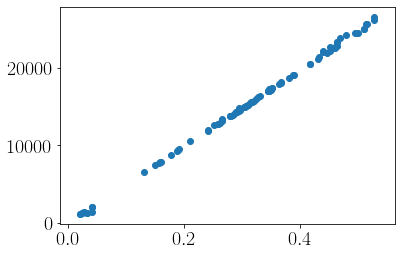

In [38]:
# Results of BCE and FL should be the same (w=0.75)
# Some differences exist due to sum (FL)/mean (BCE) and different epsilon values
print(feat_stats_df.loc[['bin_bce_0.75_l2', 'bin_floss_l2']])
plt.scatter(*degs_df_with_preds[['bin_bce_0.75_l2_ypreds_unfitted', 'bin_floss_l2_ypreds_unfitted']].values.T)

                      pcc     srocc      rmse  outlier_ratio
method_name                                                 
bin_bce_0.75_l2  0.874850  0.859031  0.144121       0.531250
bin_awbce_l2     0.858425  0.843029  0.151821       0.510417


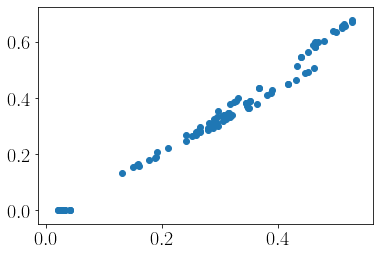

In [39]:
# BCE 0.75 works better than the adaptive version
print(feat_stats_df.loc[['bin_bce_0.75_l2', 'bin_awbce_l2']])
plt.scatter(*degs_df_with_preds[['bin_bce_0.75_l2_ypreds_unfitted', 'bin_awbce_l2_ypreds_unfitted']].values.T)

                      pcc     srocc      rmse  outlier_ratio
method_name                                                 
bin_bce_0.75_l2  0.874850  0.859031  0.144121       0.531250
bin_bce_mean     0.712993  0.721168  0.206900       0.635417


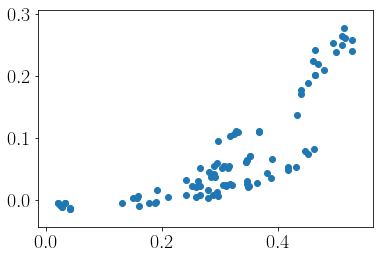

In [40]:
# BCE 0.75 is better than BCE 0.5
print(feat_stats_df.loc[['bin_bce_0.75_l2', 'bin_bce_mean']])
plt.scatter(*degs_df_with_preds[['bin_bce_0.75_l2_ypreds_unfitted', 'bin_bce_mean_ypreds_unfitted']].values.T)

                        pcc     srocc      rmse  outlier_ratio
method_name                                                   
bin_bce_mean       0.712993  0.721168  0.206900       0.635417
bin_na_bce_5_mean  0.739607  0.719249  0.201279       0.572917


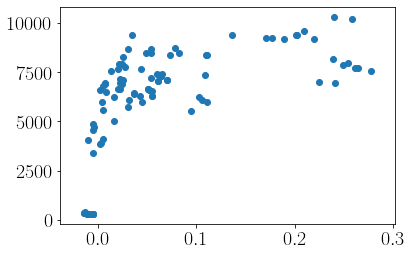

In [41]:
# naBCE performs better than BCE
print(feat_stats_df.loc[['bin_bce_mean', 'bin_na_bce_5_mean']])
plt.scatter(*degs_df_with_preds[['bin_bce_mean_ypreds_unfitted', 'bin_na_bce_5_mean_ypreds_unfitted']].values.T)

**We choose mean aggregation in all cases except bin_mse and bin_floss which perform better with L2 aggregation.**

## Best channels for perceptual losses

In [42]:
# Top 3 for binary perceptual loss
bin_ploss_df = feat_stats_df.loc[[f'bin_ploss_{i:02d}_mean' for i in range(perceptual_loss.filters)]].sort_values('rmse')
best_bin_ploss = bin_ploss_df.index[0]
bin_ploss_df.head(3)

,pcc,srocc,rmse,outlier_ratio
method_name,,,,
bin_ploss_01_mean,0.922314,0.916143,0.115424,0.406250
bin_ploss_28_mean,0.911433,0.912284,0.123886,0.427083
bin_ploss_10_mean,0.902884,0.913369,0.128534,0.479167


In [43]:
# Top 3 for tdf perceptual loss
tdf_ploss_df = feat_stats_df.loc[[f'tdf_5_ploss_{i:02d}_mean' for i in range(perceptual_loss.filters)]].sort_values('rmse')
best_tdf_ploss = tdf_ploss_df.index[0]
tdf_ploss_df.head(3)

,pcc,srocc,rmse,outlier_ratio
method_name,,,,
tdf_5_ploss_09_mean,0.950812,0.946758,0.093901,0.375000
tdf_5_ploss_02_mean,0.949589,0.944703,0.094135,0.364583
tdf_5_ploss_28_mean,0.945665,0.944167,0.099099,0.406250


**For binary, channel 1 performs best and for TDF, channel 9 performs best. Note that channels are numbered from 0.**

In [44]:
np.sqrt(np.mean(np.square((degs_df['mos']) / 4)))

0.8123115393667396

**Some channels are constant so the difference between them is zero. As a result, the MSE is equal to sqrt(E[X^2])**

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


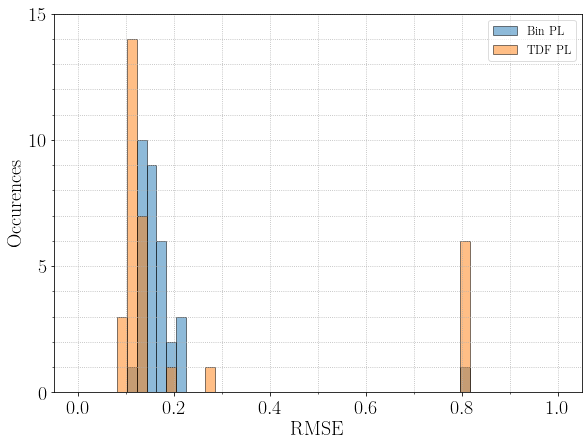

In [45]:
bin_vals = feat_stats_df.loc[[f'bin_ploss_{i:02d}_mean' for i in range(perceptual_loss.filters)]]['rmse'].values
tdf_vals = feat_stats_df.loc[[f'tdf_5_ploss_{i:02d}_mean' for i in range(perceptual_loss.filters)]]['rmse'].values

bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(figsize=(6*1.33,6))
ax.hist(bin_vals, bins, edgecolor='black', label='Bin PL', alpha=0.5)
ax.hist(tdf_vals, bins, edgecolor='black', label='TDF PL', alpha=0.5)

ax.set_xlabel('RMSE')
ax.set_ylabel('Occurences')
ax.set_yticks([0, 5, 10, 15])
ax.set_yticks([1,2,3,4,6,7,8,9,11,12,13,14], minor=True)
ax.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_xticks([0.1,0.3,0.5,0.7,0.9], minor=True)

ax.grid(which='both', linestyle=':')
ax.legend()

fig.tight_layout(pad=0)
fig.savefig(f'figs/barchart_channel_rmse.pdf')

## Focused study on relevant methods

In [46]:
not_l2_or_bin_mse_floss_l2 = lambda x: not x.endswith('_l2') or x in ['bin_bce_0.75_l2']
not_blocked = lambda x: x not in ['bin_mse_mean', 'bin_floss_mean', 'bin_bce_0.75_mean', 'bin_awbce_mean', 'min_y_psnr_color']
not_tdf_ploss_channel_or_best = lambda x: not re.search(r'tdf_5_ploss_\d\d_mean', x) or x == best_tdf_ploss
not_bin_ploss_channel_or_best = lambda x: not re.search(r'bin_ploss_\d\d_mean', x) or x == best_bin_ploss
methods_selected = [x for x in methods.keys() if not_l2_or_bin_mse_floss_l2(x) and not_blocked(x) and not_tdf_ploss_channel_or_best(x) and not_bin_ploss_channel_or_best(x)]
methods_selected

['max_d1_mse',
 'max_d2_mse',
 'min_d1_psnr',
 'min_d2_psnr',
 'bin_bce_mean',
 'bin_ploss_mean_mean',
 'bin_ploss_01_mean',
 'tdf_5_mse_mean',
 'tdf_5_ploss_mean_mean',
 'tdf_5_ploss_09_mean',
 'bin_bce_0.75_l2',
 'bin_na_bce_5_mean']

In [47]:
method_disp_names = {
    'max_d1_mse': 'D1 MSE',
    'max_d2_mse': 'D2 MSE',
    'min_d1_psnr': 'D1 PSNR',
    'min_d2_psnr': 'D2 PSNR',
    'bin_mse_l2': 'Bin MSE',
    'bin_floss_l2': 'Bin FL',
    'bin_ploss_mean_mean': 'Bin PL',
    'bin_bce_mean': 'Bin BCE',
    'bin_bce_0.75_l2': 'Bin WBCE 0.75',
    'bin_na_bce_5_mean': 'Bin naBCE',
    'bin_awbce_mean': 'Bin A-BCE',
    'tdf_5_mse_mean': 'TDF MSE',
    'tdf_5_ploss_mean_mean': 'TDF PL',
    'bin_ploss_01_mean': 'Bin PL C1',
    'tdf_5_ploss_09_mean': 'TDF PL C9',
}

In [48]:
feat_stats_df.loc[methods_selected].applymap(lambda s: float(f'{s:.3f}')).style.background_gradient(cmap='inferno', low=0.25, high=1.0, axis=1)

,pcc,srocc,rmse,outlier_ratio
method_name,,,,
max_d1_mse,0.938,0.933,0.109,0.479
max_d2_mse,0.946,0.943,0.1,0.469
min_d1_psnr,0.85,0.867,0.158,0.448
min_d2_psnr,0.9,0.898,0.129,0.5
bin_bce_mean,0.713,0.721,0.207,0.635
bin_ploss_mean_mean,0.863,0.867,0.151,0.552
bin_ploss_01_mean,0.922,0.916,0.115,0.406
tdf_5_mse_mean,0.94,0.94,0.103,0.385
tdf_5_ploss_mean_mean,0.935,0.933,0.11,0.49


In [49]:
feat_stats_df.loc[methods_selected].sort_values('rmse').applymap(lambda s: float(f'{s:.3f}')).style.background_gradient(cmap='inferno', low=0.25, high=1.0, axis=1)

,pcc,srocc,rmse,outlier_ratio
method_name,,,,
tdf_5_ploss_09_mean,0.951,0.947,0.094,0.375
max_d2_mse,0.946,0.943,0.1,0.469
tdf_5_mse_mean,0.94,0.94,0.103,0.385
max_d1_mse,0.938,0.933,0.109,0.479
tdf_5_ploss_mean_mean,0.935,0.933,0.11,0.49
bin_ploss_01_mean,0.922,0.916,0.115,0.406
min_d2_psnr,0.9,0.898,0.129,0.5
bin_bce_0.75_l2,0.875,0.859,0.144,0.531
bin_ploss_mean_mean,0.863,0.867,0.151,0.552


In [50]:
feat_stats_df.loc[methods_selected].sort_values('pcc', ascending=False).applymap(lambda s: float(f'{s:.3f}')).style.background_gradient(cmap='inferno', low=0.25, high=1.0, axis=1)

,pcc,srocc,rmse,outlier_ratio
method_name,,,,
tdf_5_ploss_09_mean,0.951,0.947,0.094,0.375
max_d2_mse,0.946,0.943,0.1,0.469
tdf_5_mse_mean,0.94,0.94,0.103,0.385
max_d1_mse,0.938,0.933,0.109,0.479
tdf_5_ploss_mean_mean,0.935,0.933,0.11,0.49
bin_ploss_01_mean,0.922,0.916,0.115,0.406
min_d2_psnr,0.9,0.898,0.129,0.5
bin_bce_0.75_l2,0.875,0.859,0.144,0.531
bin_ploss_mean_mean,0.863,0.867,0.151,0.552


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


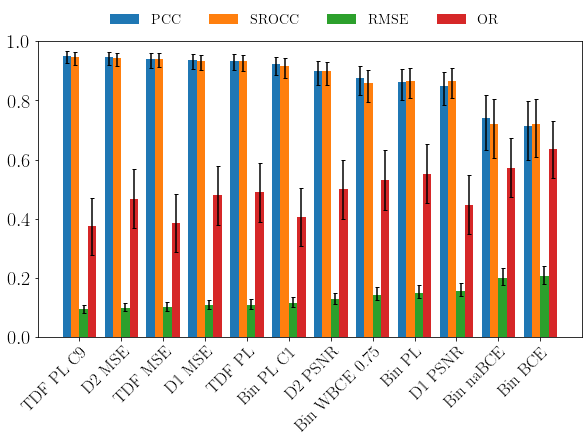

In [51]:
corr_funs = {'PCC': corr_ci, 'SROCC': corr_ci, 'RMSE': rmse_ci, 'OR': or_ci}
conf = 0.95
final_table = feat_stats_df.loc[methods_selected].groupby('method_name')[['pcc', 'srocc', 'rmse', 'outlier_ratio']].mean().sort_values('pcc', ascending=False)
labels = [method_disp_names[x] for x in final_table.index]
columns = ['PCC', 'SROCC', 'RMSE', 'OR']
values = [final_table[x].values for x in final_table.columns]

x = np.arange(len(labels)) * (len(columns) + 1)  # the label locations
width = 1.0  # the width of the bars

fig, ax = plt.subplots(figsize=(6*1.33,6))
for i in range(len(columns)):
    col = columns[i]
    val = values[i]
    offset = i - len(columns) / 2.0 + 1
    if col in ['PCC', 'SROCC', 'RMSE', 'OR']:
        corr_f = corr_funs[col]
        yerr = []
        for j in range(len(labels)):
            yerr.append(corr_f(val[j], len(degs_df_with_preds), conf))
            
        yerr = np.abs(np.vstack(yerr) - val[:, np.newaxis]).T

        rects1 = ax.bar(x + offset * width - width/2, val, width, label=col, yerr=yerr, capsize=2)
    else:
        rects1 = ax.bar(x + offset * width - width/2, val, width, label=col)

ax.set_xticks(x)
ax.set_ylim([0, 1])
plt.xticks(rotation=45, ha="right", rotation_mode='anchor')
ax.set_xticklabels(labels, fontsize='xx-large')
# ax.legend(loc="center right", bbox_to_anchor=(1.225, 0.475), frameon=False)
ax.legend(ncol=len(columns), loc="upper center", bbox_to_anchor=(0.49, 1.14), frameon=False, fontsize='x-large')

fig.tight_layout(pad=0)

plt.show()

fig.savefig(f'figs/barchart_with_ci.pdf')

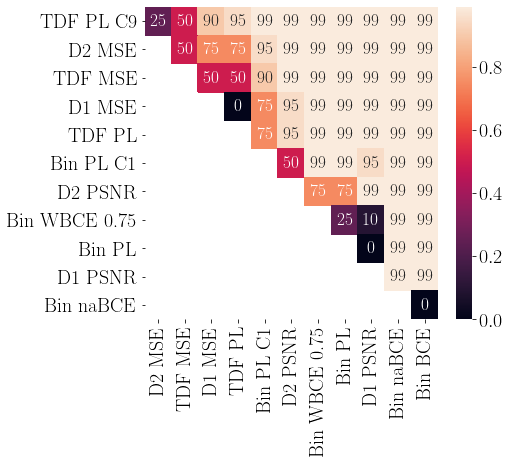

In [52]:
cur_column = 'pcc'
ascending = False
pvalues = []
cur_methods_selected = list(feat_stats_df.loc[methods_selected].sort_values('pcc', ascending=ascending).index)
for i in trange(len(cur_methods_selected)):
    mth0 = cur_methods_selected[i]
    d = {'method_name': mth0}
    for j in range(i+1, len(cur_methods_selected)):
        mth1 = cur_methods_selected[j]
        d[mth1] = compare_corr_max_conf(degs_df_with_preds['mos'], degs_df_with_preds[mth0 + '_ypreds'], degs_df_with_preds[mth1 + '_ypreds'], mode='spearman')
    pvalues.append(d)
    
pvalues_df = pd.DataFrame(pvalues).set_index('method_name')
pvalues_df.index = list(map(method_disp_names.get, pvalues_df.index))
pvalues_df = pvalues_df.rename(columns={s: method_disp_names.get(s) for s in pvalues_df.columns})

fig, ax = plt.subplots(figsize=(7,6.25))
sns.heatmap(pvalues_df.iloc[:-1], annot=True, fmt="2.0%", annot_kws={'fontsize': 'xx-large'})

fig.tight_layout(pad=0)
fig.savefig(f'figs/heatmap_pcc_ci.pdf')

## Study by Point Cloud and by Codec

In [53]:
group_data = []
for key, group in degs_df_with_preds.groupby('codec_id'):
    for method in methods_selected:
        stats = pcqa_stats(method, group)
        group_data.append({'codec_id': key, **stats})
group_df = pd.DataFrame(group_data).set_index(['codec_id', 'method_name'])

## Charts

In [54]:
methods_selected

['max_d1_mse',
 'max_d2_mse',
 'min_d1_psnr',
 'min_d2_psnr',
 'bin_bce_mean',
 'bin_ploss_mean_mean',
 'bin_ploss_01_mean',
 'tdf_5_mse_mean',
 'tdf_5_ploss_mean_mean',
 'tdf_5_ploss_09_mean',
 'bin_bce_0.75_l2',
 'bin_na_bce_5_mean']

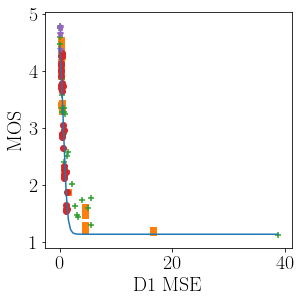

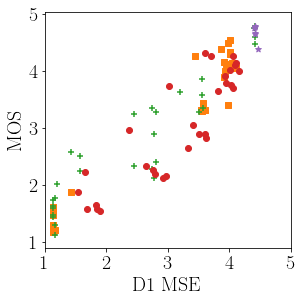

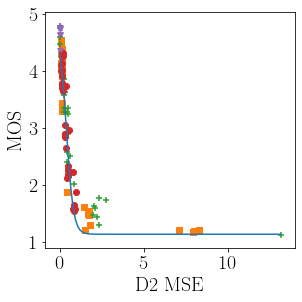

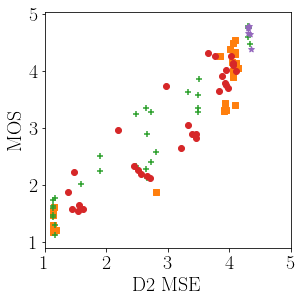

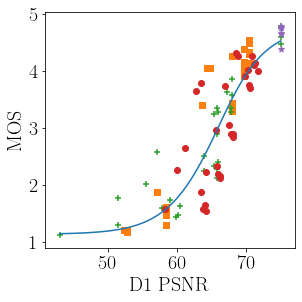

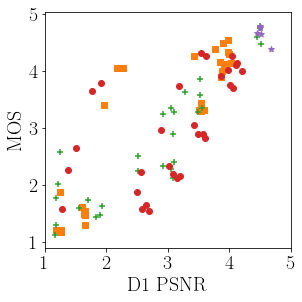

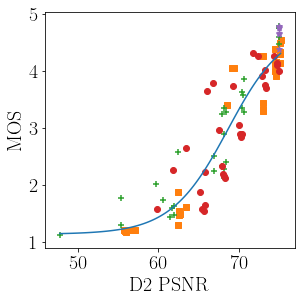

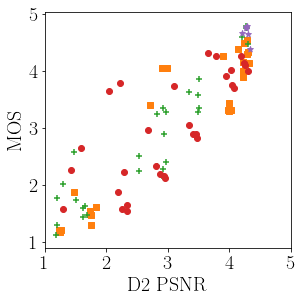

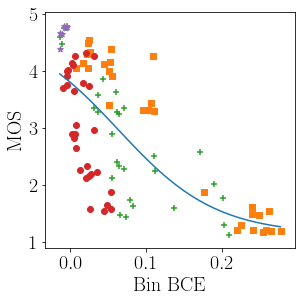

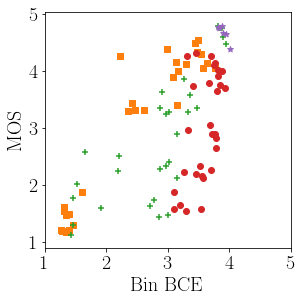

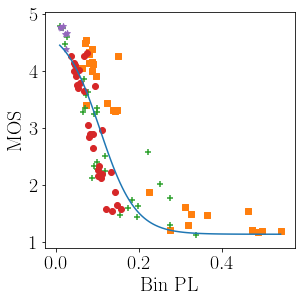

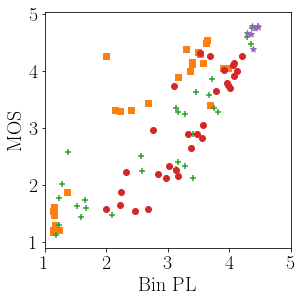

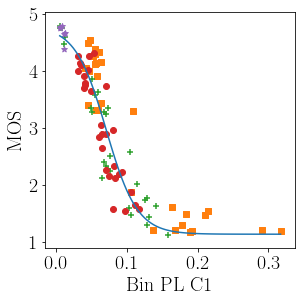

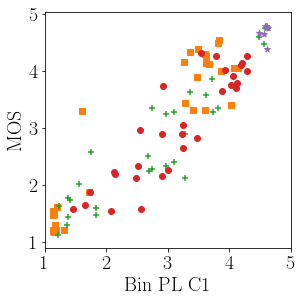

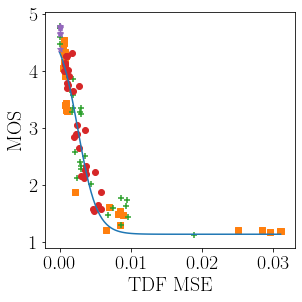

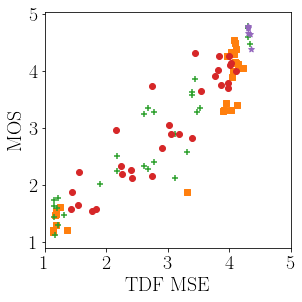

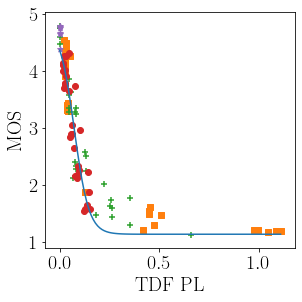

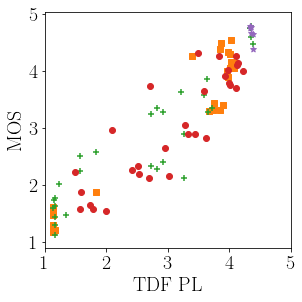

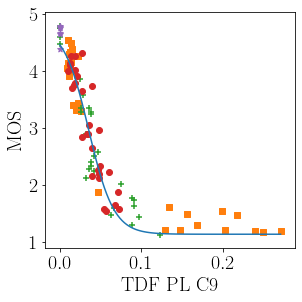

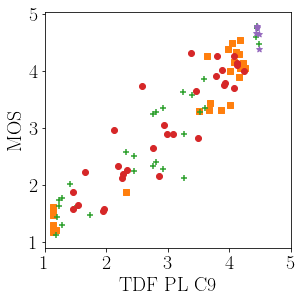

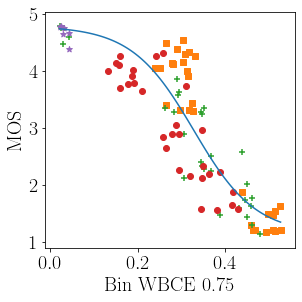

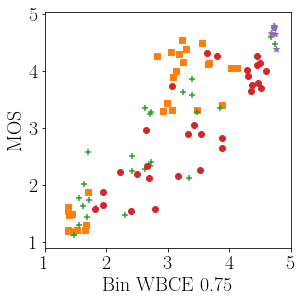

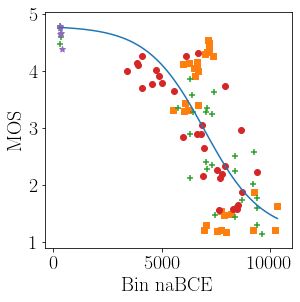

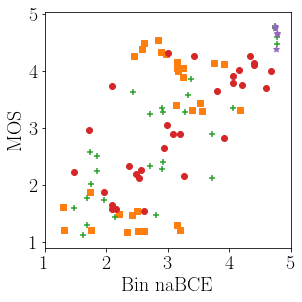

In [55]:
plt.rcParams.update({'figure.max_open_warning': 0})
codec_disp_names = {
    'GPCC_OCT_PRED': 'G-PCC Octree',
    'GPCC_TRI_PRED': 'G-PCC Trisoup',
    'VPCC_AI': 'V-PCC',
    'REF': 'Reference',
}
codec_ids = ['GPCC_OCT_PRED', 'GPCC_TRI_PRED', 'VPCC_AI', 'REF']
# Marker and color by point cloud
for method_name in tqdm(methods_selected, desc='Plotting results'):
    method_data = exp_data[method_name]
    models = method_data['models']
    ypreds = method_data['ypreds']
    ypreds_unfitted = method_data['ypreds_unfitted']
    
    try:
        fig, ax = plt.subplots(figsize=(4,4))
        fig2, ax2 = plt.subplots(figsize=(4,4))
        final_name = method_disp_names.get(method_name, method_name)
        esc_method_name = esc_latex(final_name)
        ax.set_xlabel(esc_method_name)
        ax.set_ylabel('MOS')
        ax2.set_xlabel(esc_method_name)
        ax2.set_ylabel('MOS')
        ax2.set_xticks([1,2,3,4,5])
        ax2.set_xlim([1,5])

        mark = mpu.markers_cycle()
        colors = mpu.colors_cycle()
        mark2 = mpu.markers_cycle()
        colors2 = mpu.colors_cycle()

        range_arr = np.linspace(np.min(ypreds_unfitted), np.max(ypreds_unfitted), 100)
        ax.plot(range_arr, np.mean(np.vstack([model.predict_fit(range_arr) for model in models]), axis=0), label='Logistic', color=next(colors))
        next(colors2)

        for codec_id in codec_ids:
            idx_test = (degs_df['codec_id'] == codec_id).values
            ypred = ypreds[idx_test]
            mos_test = degs_df['mos'].iloc[idx_test]
            mos_ci = degs_df['mos_ci'].iloc[idx_test]
            ypred_fitted = ypred
            ypred_unfitted = ypreds_unfitted[idx_test]
            codec_name = codec_disp_names[codec_id]

            ax.scatter(ypred_unfitted, mos_test, label=codec_name, marker=next(mark), color=next(colors))
            ax2.scatter(ypred, mos_test, label=codec_name, marker=next(mark2), color=next(colors2))

        fig.tight_layout(pad=0)
        fig.savefig(f'figs/fit_{method_name}.pdf')
        fig2.tight_layout(pad=0)
        fig2.savefig(f'figs/fit_{method_name}_postfit.pdf')
    except TypeError:
        print(method_name, ' plot failure')

In [56]:
# Render separate legend for previous plot
def render_legend(labels, figsize=None, orientation='horizontal'):
    assert orientation in ('horizontal', 'vertical')
    linestyles = mpu.linestyles_cycle()
    markers = mpu.markers_cycle()
    colors = mpu.colors_cycle()
    if figsize is None:
        length_estimate = 0
        for l in labels:
            length_estimate += 0.4 + 0.166 * len(l)
        figsize = (length_estimate, 0.25)

    fig = plt.figure()
    figlegend = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    lines = []
    for i in range(len(labels)):
        if i == 0:
            line = ax.plot([0], [0], linestyle=next(linestyles), color=next(colors), marker='None')
        else:
            line = ax.plot([0], [0], marker=next(markers), color=next(colors), linestyle='None')
        lines.append(line[0])
    params = {}
    if orientation == 'horizontal':
        params['ncol'] = len(labels)
    figlegend.legend(lines, labels, 'center', frameon=False, columnspacing=1.0, handletextpad=0.5, **params)
    fig.canvas.draw()
    figlegend.tight_layout()
    return figlegend

fig = render_legend(['Logistic'] + [codec_disp_names[x] for x in codec_ids], figsize=(8,0.4))
fig.savefig('figs/fit_legend.pdf')
plt.close(fig)
plt.close()
from IPython.display import IFrame
IFrame('figs/fit_legend.pdf', width=1280, height=100)

## Crossvalidation splitwise metrics

In [57]:
eval_df = pd.DataFrame(eval_data)
eval_df.set_index(['method_name', 'pc_name']).loc[methods_selected, ['pcc', 'srocc', 'rmse', 'outlier_ratio']].applymap(lambda s: float(f'{s:.3f}')).style.background_gradient(cmap='inferno', low=0.25, high=1.0, axis=1)

## Paper Utilities

In [58]:
# Table for each method
final_table = feat_stats_df.loc[methods_selected].sort_values('rmse').applymap(lambda s: float(f'{s:.3f}'))
ljust_n = 10
print(' & '.join(['Method'.ljust(ljust_n), *[x.rjust(13) for x in ['PCC', 'SROCC', 'RMSE', 'OR']]]), '\\\\', '\\midrule')
for method_name, row in final_table.iterrows():
    if method_name == 'tdf_5_ploss_09_mean':
        val_str = [f'$\\bm{{{x:5.3f}}}$'.rjust(13) for x in row.values]
    else:
        val_str = [f'${x:5.3f}$'.rjust(13) for x in row.values]
    print(' & '.join([method_disp_names[method_name].ljust(ljust_n), *val_str]), '\\\\', '\\hdashline')

Method     &           PCC &         SROCC &          RMSE &            OR \\ \midrule
TDF PL C9  &  $\bm{0.951}$ &  $\bm{0.947}$ &  $\bm{0.094}$ &  $\bm{0.375}$ \\ \hdashline
D2 MSE     &       $0.946$ &       $0.943$ &       $0.100$ &       $0.469$ \\ \hdashline
TDF MSE    &       $0.940$ &       $0.940$ &       $0.103$ &       $0.385$ \\ \hdashline
D1 MSE     &       $0.938$ &       $0.933$ &       $0.109$ &       $0.479$ \\ \hdashline
TDF PL     &       $0.935$ &       $0.933$ &       $0.110$ &       $0.490$ \\ \hdashline
Bin PL C1  &       $0.922$ &       $0.916$ &       $0.115$ &       $0.406$ \\ \hdashline
D2 PSNR    &       $0.900$ &       $0.898$ &       $0.129$ &       $0.500$ \\ \hdashline
Bin WBCE 0.75 &       $0.875$ &       $0.859$ &       $0.144$ &       $0.531$ \\ \hdashline
Bin PL     &       $0.863$ &       $0.867$ &       $0.151$ &       $0.552$ \\ \hdashline
D1 PSNR    &       $0.850$ &       $0.867$ &       $0.158$ &       $0.448$ \\ \hdashline
Bin naBCE  &       $

In [59]:
# RMSE only table by compression method for each method
codec_ids = ['GPCC_OCT_PRED', 'GPCC_TRI_PRED', 'VPCC_AI']
columns = ['rmse']
print('Method'.ljust(ljust_n), ' & ', ' & '.join([' & '.join([codec_disp_names[x].rjust(18) for x in codec_ids])]), '\\\\', '\\midrule[\\heavyrulewidth]')
for method in feat_stats_df.loc[methods_selected].sort_values('rmse').index:
    vals = []
    for codec_id in codec_ids:
        row = group_df.loc[(codec_id, method)]
        cur_vals = []
        for col in columns:
            cur_val = row[col]
            cur_codec_col = group_df.query(f'codec_id == "{codec_id}"')[col]
            if col in ['pcc', 'srocc']:
                cur_best = cur_codec_col.nlargest(2)
            else:
                cur_best = cur_codec_col.nsmallest(2)
            if cur_val == cur_best[0]:
                cur_vals.append(f'$\\bm{{{cur_val:5.3f}}}$'.rjust(18))
            elif cur_val == cur_best[1]:
                cur_vals.append(f'$\\mathit{{{cur_val:5.3f}}}$'.rjust(18))
            else:
                cur_vals.append(f'${cur_val:5.3f}$'.rjust(18))
        vals.append(cur_vals)
    print(method_disp_names[method].ljust(10), ' & ', ' & '.join([' & '.join(x) for x in vals]), '\\\\', '\\hdashline')

Method      &        G-PCC Octree &      G-PCC Trisoup &              V-PCC \\ \midrule[\heavyrulewidth]
TDF PL C9   &        $\bm{0.078}$ &       $\bm{0.101}$ &            $0.106$ \\ \hdashline
D2 MSE      &             $0.094$ &   $\mathit{0.103}$ &   $\mathit{0.103}$ \\ \hdashline
TDF MSE     &             $0.106$ &            $0.106$ &       $\bm{0.098}$ \\ \hdashline
D1 MSE      &    $\mathit{0.082}$ &            $0.126$ &            $0.119$ \\ \hdashline
TDF PL      &             $0.087$ &            $0.127$ &            $0.115$ \\ \hdashline
Bin PL C1   &             $0.138$ &            $0.107$ &            $0.109$ \\ \hdashline
D2 PSNR     &             $0.110$ &            $0.108$ &            $0.166$ \\ \hdashline
Bin WBCE 0.75  &             $0.163$ &            $0.112$ &            $0.164$ \\ \hdashline
Bin PL      &             $0.186$ &            $0.130$ &            $0.142$ \\ \hdashline
D1 PSNR     &             $0.156$ &            $0.117$ &            $0.202$ \\ \hd

In [60]:
block_aggregation = ['L2', 'Mean']
methods_data = ['min_d1_psnr', 'min_d2_psnr', 'bin_bce_mean', 'bin_na_bce_5_mean', 'bin_bce_0.75_l2',
                'bin_ploss_mean_mean', 'bin_ploss_01_mean', 'tdf_5_mse_mean', 'tdf_5_ploss_mean_mean', 'tdf_5_ploss_09_mean']
methods_desc = {
    'max_d1_mse': 'Point-to-point MSE',
    'max_d2_mse': 'Point-to-plane MSE',
    'min_d1_psnr': 'Point-to-point PSNR',
    'min_d2_psnr': 'Point-to-plane PSNR',
    'bin_bce_mean': 'Binary cross entropy',
    'bin_na_bce_5_mean': 'Neighborhood adaptive binary cross entropy',
    'bin_bce_0.75_l2': 'Weighted binary cross entropy with $w = 0.75$',
    'bin_mse_l2': 'Binary signal MSE',
    'bin_ploss_mean_mean': 'Perceptual loss (explicit) on all channels',
    'bin_ploss_01_mean': 'Perceptual loss (explicit) on channel 1',
    'tdf_5_mse_mean': 'Truncated distance field (TDF) MSE',
    'tdf_5_ploss_mean_mean': 'Perceptual loss (implicit) over all channels',
    'tdf_5_ploss_09_mean': 'Perceptual loss (implicit) on channel 9',}
methods_df = []
for x in methods_data:
    data = {}
    data['method'] = x
    data['domain'] = 'Voxel Grid' if 'bin_' in x or 'tdf_' in x else 'Point'
    
    if 'y_psnr' in x:
        signal_type = 'Colors'
    elif 'bin_' in x:
        signal_type = 'Binary'
    elif 'tdf_' in x:
        signal_type = 'Distances'
    else:
        signal_type = 'Coordinates'
    data['signal_type'] = signal_type
    
    xmark = '\\textcolor{Red}{\\xmark}'
    cmark = '\\textcolor{Green}{\\cmark}'
    
#     data['block_partitioning'] = 'Yes' if 'bin_' in x or 'tdf_' in x else ''
    data['block_aggregation'] = 'L2' if 'l2' in x else 'L1' if 'mean' in x else xmark
    data['learning_based'] = cmark if 'ploss' in x else xmark
    data['description'] = methods_desc[x]
    
    methods_df.append(data)
methods_df = pd.DataFrame(methods_df)
for _, row in methods_df.iterrows():
    vals = row[['method', 'signal_type', 'block_aggregation', 'learning_based', 'description']].values
    vals[0] = method_disp_names[vals[0]]
    print('&', ' & '.join(vals), '\\\\ \\cdashline{2-6}')

& D1 PSNR & Coordinates & \textcolor{Red}{\xmark} & \textcolor{Red}{\xmark} & Point-to-point PSNR \\ \cdashline{2-6}
& D2 PSNR & Coordinates & \textcolor{Red}{\xmark} & \textcolor{Red}{\xmark} & Point-to-plane PSNR \\ \cdashline{2-6}
& Bin BCE & Binary & L1 & \textcolor{Red}{\xmark} & Binary cross entropy \\ \cdashline{2-6}
& Bin naBCE & Binary & L1 & \textcolor{Red}{\xmark} & Neighborhood adaptive binary cross entropy \\ \cdashline{2-6}
& Bin WBCE 0.75 & Binary & L2 & \textcolor{Red}{\xmark} & Weighted binary cross entropy with $w = 0.75$ \\ \cdashline{2-6}
& Bin PL & Binary & L1 & \textcolor{Green}{\cmark} & Perceptual loss (explicit) on all channels \\ \cdashline{2-6}
& Bin PL C1 & Binary & L1 & \textcolor{Green}{\cmark} & Perceptual loss (explicit) on channel 1 \\ \cdashline{2-6}
& TDF MSE & Distances & L1 & \textcolor{Red}{\xmark} & Truncated distance field (TDF) MSE \\ \cdashline{2-6}
& TDF PL & Distances & L1 & \textcolor{Green}{\cmark} & Perceptual loss (implicit) over all chan

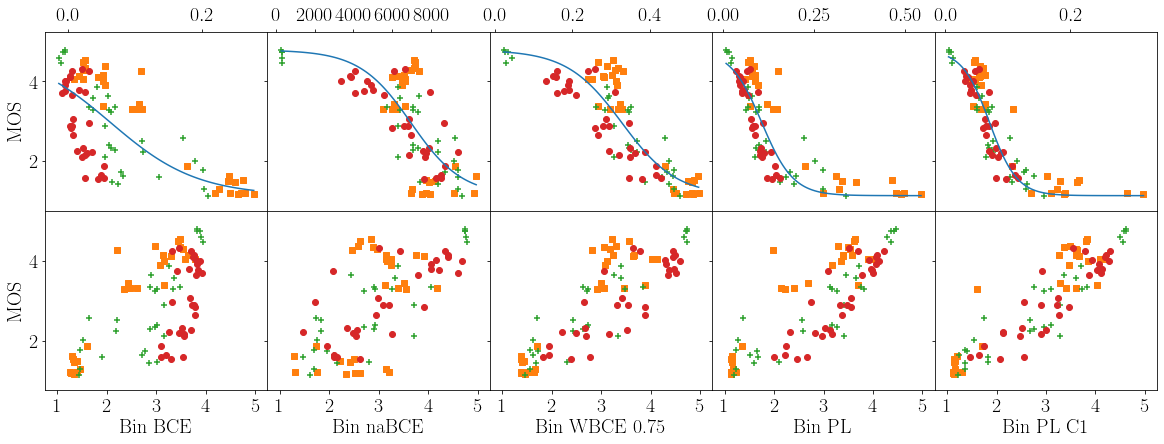

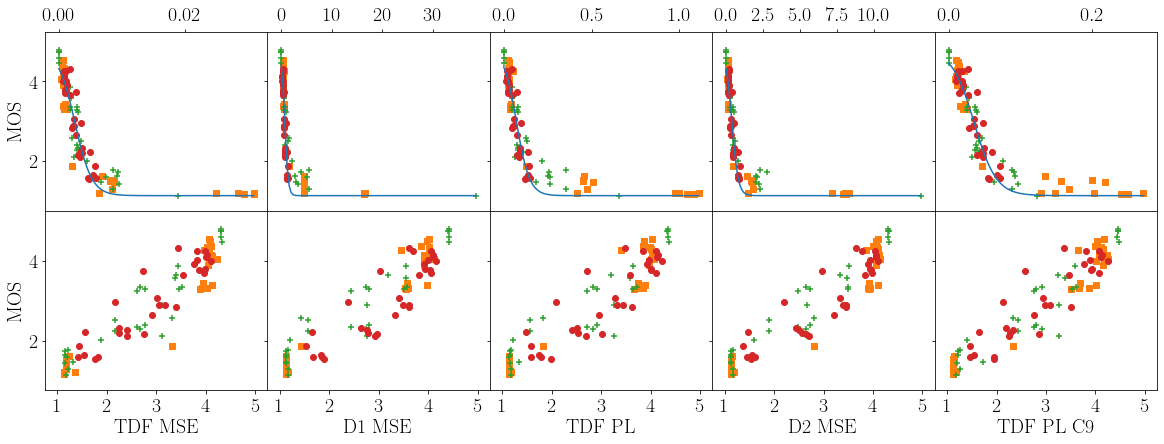

In [61]:
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
# Marker and color by point cloud
cur_mths = [['bin_bce_mean', 'bin_na_bce_5_mean', 'bin_bce_0.75_l2', 'bin_ploss_mean_mean', 'bin_ploss_01_mean'],
           ['tdf_5_mse_mean', 'max_d1_mse', 'tdf_5_ploss_mean_mean', 'max_d2_mse', 'tdf_5_ploss_09_mean']]
auto_locator = MaxNLocator(nbins=4, steps=[1, 2, 2.5, 5, 10])
for k, cur_mth in enumerate(cur_mths):
    i = 0
    fig, axs = plt.subplots(2, 5, figsize=(16,6), sharey=True, gridspec_kw = {'wspace':0, 'hspace':0})
    for method_name in tqdm(cur_mth, desc='Plotting results'):
        method_data = exp_data[method_name]
        models = method_data['models']
        ypreds = method_data['ypreds']
        ypreds_unfitted = method_data['ypreds_unfitted']

        ax = axs[0, i]
        ax2 = axs[1, i]

        try:
            final_name = method_disp_names.get(method_name, method_name)
            esc_method_name = esc_latex(final_name)
    #         ax.set_xlabel(esc_method_name)
            ax.xaxis.tick_top()
            ax.tick_params(labelbottom=False, labeltop=True)

            xmin, xmax = np.min(ypreds_unfitted), np.max(ypreds_unfitted)
            xrange = xmax - xmin
            if np.log10(xrange) > 1:
                xticks = auto_locator.tick_values(xmin + xrange*0, xmax - xrange*0.25)
                ax.set_xticks(xticks)

            ax.set_ylim([1-0.25,5+0.25])
            if i == 0:
                ax.set_ylabel('MOS')
                ax2.set_ylabel('MOS')
            ax2.set_xlabel(esc_method_name)
            ax2.set_xticks([1,2,3,4,5])
            ax2.set_xlim([1-0.25,5+0.25])
            ax2.set_ylim([1-0.25,5+0.25])


            mark = mpu.markers_cycle()
            colors = mpu.colors_cycle()
            mark2 = mpu.markers_cycle()
            colors2 = mpu.colors_cycle()

            range_arr = np.linspace(np.min(ypreds_unfitted), np.max(ypreds_unfitted), 100)
            ax.plot(range_arr, np.mean(np.vstack([model.predict_fit(range_arr) for model in models]), axis=0), label='Logistic', color=next(colors))
            next(colors2)

            for codec_id in codec_ids:
                idx_test = (degs_df['codec_id'] == codec_id).values
                ypred = ypreds[idx_test]
                mos_test = degs_df['mos'].iloc[idx_test]
                mos_ci = degs_df['mos_ci'].iloc[idx_test]
                ypred_fitted = ypred
                ypred_unfitted = ypreds_unfitted[idx_test]
                codec_name = codec_disp_names[codec_id]

                ax.scatter(ypred_unfitted, mos_test, label=codec_name, marker=next(mark), color=next(colors))
                ax2.scatter(ypred, mos_test, label=codec_name, marker=next(mark2), color=next(colors2))

        except TypeError:
            print(method_name, ' plot failure')
        i += 1
    fig.tight_layout(pad=0.1)
    fig.savefig(f'figs/fit_methods_{k}.pdf')

In [62]:
# Verify that the two formulations yield the same results
def focal_loss_test1(y_true, y_pred, alpha=0.75, gamma=2.0):
    pt_1 = np.where(y_true == 1, y_pred, np.ones_like(y_pred))
    pt_0 = np.where(y_true == 0, y_pred, np.zeros_like(y_pred))

    pt_1 = np.clip(pt_1, 1e-3, .999)
    pt_0 = np.clip(pt_0, 1e-3, .999)

    return -np.sum(alpha * np.power(1. - pt_1, gamma) * np.log(pt_1)) - np.sum((1-alpha) * np.power(pt_0, gamma) * np.log(1. - pt_0))

def focal_loss_test2(y_true, y_pred, alpha=0.75, gamma=2.0):
    y_pred = np.clip(y_pred, 1e-3, .999)

    return -np.sum(alpha * y_true * np.power(1. - y_pred, gamma) * np.log(y_pred) + (1-alpha) * (1-y_true) * np.power(y_pred, gamma) * np.log(1. - y_pred))

fl_test_true = np.array([0, 1, 0, 0, 1])
fl_test_pred = np.array([0.25, 0.75, 0, 0.5, 0.2])
fl_test_pred2 = np.array([1, 0, 1, 0, 1])
print(focal_loss_test1(fl_test_true, fl_test_pred))
print(focal_loss_test2(fl_test_true, fl_test_pred))

0.8338320292831022
0.8338320265317263


In [63]:
# Verify that wbce is focal loss with averaging when true and false values are binary (gamma has no impact)
def wbce_test(y_true, y_pred, eps=1e-16, w=0.5):
    assert 0 <= w <= 1
    return -np.mean(w * y_true * np.log(y_pred + eps) + (1 - w) * (1 - y_true) * np.log(1 - y_pred + eps))
fl_test_pred2 = np.array([1, 0, 1, 0, 1])
print(wbce_test(fl_test_true, fl_test_pred2, w=0.75, eps=1e-3) * 5)
print(focal_loss_test1(fl_test_true, fl_test_pred2))
print(focal_loss_test2(fl_test_true, fl_test_pred2))

8.63369459839459
8.617433348976189
8.617433346224816


In [64]:
tf.__version__

'1.15.0'

In [65]:
# Complete table by compression method
codec_ids = ['GPCC_OCT_PRED', 'GPCC_TRI_PRED', 'VPCC_AI']
columns = ['pcc', 'srocc', 'rmse']
print('Method'.ljust(ljust_n), ' && ', ' && '.join([' & '.join([x.rjust(13) for x in ['PCC', 'SROCC', 'RMSE']])] * len(codec_ids)), '\\\\', '\\midrule[\\heavyrulewidth]')
for method in feat_stats_df.loc[methods_selected].sort_values('rmse').index:
    vals = []
    for codec_id in codec_ids:
        row = group_df.loc[(codec_id, method)]
        cur_vals = []
        for col in columns:
            cur_val = row[col]
            cur_codec_col = group_df.query(f'codec_id == "{codec_id}"')[col]
            if col in ['pcc', 'srocc']:
                cur_best = cur_codec_col.nlargest(2)
            else:
                cur_best = cur_codec_col.nsmallest(2)
            if cur_val == cur_best[0]:
                cur_vals.append(f'$\\bm{{{cur_val:5.3f}}}$'.rjust(13))
            elif cur_val == cur_best[1]:
                cur_vals.append(f'$\\mathit{{{cur_val:5.3f}}}$'.rjust(13))
            else:
                cur_vals.append(f'${cur_val:5.3f}$'.rjust(13))
        vals.append(cur_vals)
    print(method_disp_names[method].ljust(10), ' && ', ' && '.join([' & '.join(x) for x in vals]), '\\\\', '\\hdashline')

Method      &&            PCC &         SROCC &          RMSE &&           PCC &         SROCC &          RMSE &&           PCC &         SROCC &          RMSE \\ \midrule[\heavyrulewidth]
TDF PL C9   &&  $\mathit{0.975}$ & $\mathit{0.859}$ &  $\bm{0.078}$ &&       $0.936$ &       $0.910$ &  $\bm{0.101}$ &&       $0.897$ &       $0.850$ &       $0.106$ \\ \hdashline
D2 MSE      &&        $0.962$ &       $0.829$ &       $0.094$ &&  $\bm{0.954}$ &  $\bm{0.924}$ & $\mathit{0.103}$ && $\mathit{0.903}$ &       $0.860$ & $\mathit{0.103}$ \\ \hdashline
TDF MSE     &&        $0.952$ &       $0.839$ &       $0.106$ &&       $0.933$ &       $0.917$ &       $0.106$ &&  $\bm{0.912}$ &  $\bm{0.867}$ &  $\bm{0.098}$ \\ \hdashline
D1 MSE      &&   $\bm{0.976}$ &       $0.851$ & $\mathit{0.082}$ && $\mathit{0.937}$ & $\mathit{0.918}$ &       $0.126$ &&       $0.876$ &       $0.844$ &       $0.119$ \\ \hdashline
TDF PL      &&        $0.970$ &       $0.840$ &       $0.087$ &&       $0.918$ &       $0.9

In [66]:
# RMSE by channel
assert perceptual_loss.filters == perceptual_loss_tdf.filters
n = perceptual_loss.filters
arr = np.zeros((n, 2))
for i in range(n):
    bin_name = f'bin_ploss_{i:02d}_mean'
    tdf_name = f'tdf_5_ploss_{i:02d}_mean'
    arr[i, 0] = feat_stats_df.loc[bin_name]['rmse']
    arr[i, 1] = feat_stats_df.loc[tdf_name]['rmse']

arr = np.round(arr, 3)
    
for i in range(n):
    vals = arr[i]
    strs = []
    for j in range(len(vals)):
        worst_val = np.max(arr[:, j])
        best_vals = np.partition(np.unique(arr[:, j]), 1)[:2]
        x = vals[j]
        if x == best_vals[0]:
            strs.append(f'$\\bm{{{x:.3f}}}$')
        elif x == best_vals[1]:
            strs.append(f'$\\mathit{{{x:.3f}}}$')
        elif x == worst_val:
            strs.append(f'$\\underline{{{x:.3f}}}$')
        else:
            strs.append(f'${x:.3f}$')
    strs = [x.rjust(20) for x in strs]
    
    print(str(i).rjust(2), '&', ' & '.join(strs), '\\\\ \\hdashline')

 0 &              $0.145$ &              $0.125$ \\ \hdashline
 1 &         $\bm{0.115}$ &              $0.112$ \\ \hdashline
 2 &              $0.151$ &         $\bm{0.094}$ \\ \hdashline
 3 &              $0.170$ &              $0.117$ \\ \hdashline
 4 &              $0.216$ &              $0.109$ \\ \hdashline
 5 &              $0.130$ &              $0.114$ \\ \hdashline
 6 &              $0.142$ &              $0.126$ \\ \hdashline
 7 &              $0.187$ &              $0.132$ \\ \hdashline
 8 &              $0.141$ &  $\underline{0.812}$ \\ \hdashline
 9 &              $0.192$ &         $\bm{0.094}$ \\ \hdashline
10 &              $0.129$ &              $0.118$ \\ \hdashline
11 &              $0.163$ &              $0.106$ \\ \hdashline
12 &              $0.163$ &              $0.118$ \\ \hdashline
13 &              $0.155$ &              $0.119$ \\ \hdashline
14 &              $0.171$ &              $0.185$ \\ \hdashline
15 &              $0.156$ &              $0.108$ \\ \hd

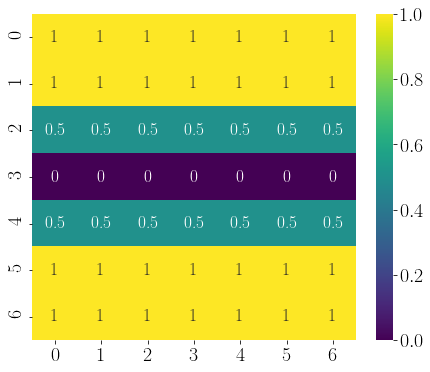

In [67]:
pts = np.array([[3,0], [3,1], [3,2], [3,3], [3,4], [3,5], [3,6]])
pts_shape = [7,7]
fig = plt.figure(figsize=(6,5))
# sns.heatmap(distance_grid_2d(pts, pts_shape, ub=np.sqrt(2*2**2)), cmap='viridis', annot=True, annot_kws={'fontsize': 'xx-large'})
dgrid = distance_grid_2d(pts, pts_shape, ub=np.sqrt(2**2))
sns.heatmap(dgrid, cmap='viridis', annot=True, annot_kws={'fontsize': 'xx-large'})

fig.tight_layout(pad=0.1)
plt.show()
fig.savefig(f'figs/tdf.pdf')

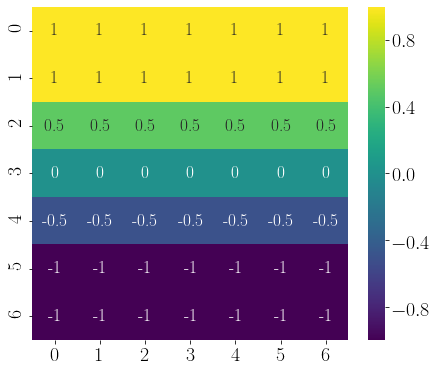

In [68]:
# Simulate signed distance field
fig = plt.figure(figsize=(6,5))
sdgrid = dgrid.copy()
sdgrid[4:] = -dgrid[4:]
sns.heatmap(sdgrid, cmap='viridis', annot=True, annot_kws={'fontsize': 'xx-large'})

fig.tight_layout(pad=0.1)
plt.show()
fig.savefig(f'figs/tsdf.pdf')

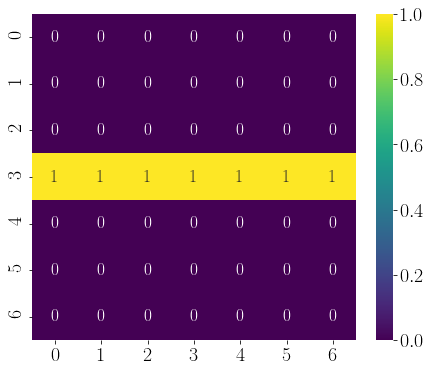

In [69]:
def pts_to_vx_2d(pts, block_shape, block):
    block.fill(0)
    if pts is None or len(pts) == 0:
        return block
    pts = pts.astype(np.uint32)
    block[pts[:, 0], pts[:, 1]] = 1
    return block

fig = plt.figure(figsize=(6,5))
sns.heatmap(pts_to_vx_2d(pts, pts_shape, np.zeros(pts_shape)), cmap='viridis', annot=True, annot_kws={'fontsize': 'xx-large'})

fig.tight_layout(pad=0.1)
plt.show()
fig.savefig(f'figs/binary.pdf')